In [329]:
import pandas as pd 
import numpy as np 
import ast
import re

# Clean CMU dataset and filter horror movies

In [330]:
CMU_headers = ['Weekipedia_ID', 'Freebase_ID', 'Name', 'Release_date', 'Revenue', 'Runtime', 'Language', 'Countries', 'Genres']
CMU = pd.read_csv('MovieSummaries/movie.metadata.tsv', sep='\t', names=CMU_headers)

In [331]:
CMU['Release_year'] = CMU['Release_date'].astype(str).str.extract(r'(\d{4})')
CMU['Release_year'] = pd.to_numeric(CMU['Release_year'])

In [332]:
def extract_words(column):
    return column.apply(ast.literal_eval).apply(lambda x: list(x.values()))

cleaning_columns = ['Language', 'Genres', 'Countries']

for column_name in cleaning_columns:
    CMU[column_name+"_clean"] = extract_words(CMU[column_name])

def clean_language(language_string):
    return re.sub(" Language", "", language_string)

CMU.Language_clean = CMU.Language_clean.apply(lambda lang_list: list(map(clean_language, lang_list)))

isHorrorMovie = CMU['Genres_clean'].apply(lambda l: 'Horror' in l)
horror_df = CMU[isHorrorMovie]

In [333]:
CMU = CMU.drop(['Release_date', 'Language', 'Countries', 'Genres'], axis=1)

In [334]:
CMU_horror_df = CMU[CMU['Genres_clean'].apply(lambda l: 'Horror' in l)]

CMU_horror_df.shape

(5280, 9)

# Clean additional horror movies dataset

In [335]:
horror_df = pd.read_csv('horror_movies.csv')

In [336]:
horror_df['Release_year'] = horror_df['release_date'].astype(str).str.extract(r'(\d{4})')
horror_df['Release_year'] = pd.to_numeric(horror_df['Release_year'])
horror_df = horror_df.drop(['original_title', 'poster_path', 'status', 'adult', 'backdrop_path', 'collection', 'release_date'], axis=1)

horror_df.shape

(32540, 14)

In [337]:
horror_df['genre_names'] = horror_df['genre_names'].str.split(',')

# Merging the two datasets 

In [338]:
Horror_movies = pd.merge(CMU_horror_df, horror_df, left_on='Name',right_on='title', how='outer')

In [339]:
Horror_movies['Name'] = Horror_movies['Name'].combine_first(Horror_movies['title'])
Horror_movies['Release_year'] = Horror_movies['Release_year_x'].combine_first(Horror_movies['Release_year_y'])
Horror_movies['Runtime'] = Horror_movies['Runtime'].combine_first(Horror_movies['runtime'])
Horror_movies['Revenue'] = Horror_movies['Revenue'].combine_first(Horror_movies['revenue'])
Horror_movies['Genres'] = Horror_movies['Genres_clean'].combine_first(Horror_movies['genre_names'])

Horror_movies = Horror_movies.drop(['title', 'Release_year_x', 'Release_year_y', 'runtime', 'revenue', 'Genres_clean', 'genre_names'], axis=1)

In [340]:
Horror_movies['ID'] = Horror_movies.index + 1 
Horror_movies = Horror_movies.drop('id', axis=1)

# Creating a text file with all summaries

In [341]:
CMU_plot_summaries = pd.read_csv('HorrorMovieSummaries.txt', sep='\t', header=None, names=['Weekipedia_ID', 'summary'])

In [342]:
merged_df = Horror_movies.copy()

In [343]:
# Ensure that both 'wiki_id' columns are of the same type
CMU_plot_summaries['Weekipedia_ID'] = CMU_plot_summaries['Weekipedia_ID'].astype(str)
merged_df['Weekipedia_ID'] = merged_df['Weekipedia_ID'].astype(str)

# Merge on 'wiki_id' to get the summaries in merged_df
merged_df = pd.merge(merged_df, CMU_plot_summaries, on='Weekipedia_ID', how='left')

In [344]:
merged_df['Summary'] = merged_df['overview'].combine_first(merged_df['summary'])

In [345]:
# Define the output file path
output_file = 'Summaries.txt'

# Write summaries to the output file
with open(output_file, 'w') as f:
    for _, row in merged_df.iterrows():
        # Write each line in the format: new ID followed by the summary
        f.write(f"{row['ID']}\t{row['Summary']}\n")

In [346]:
# Define the output file path
output_file = 'Taglines.txt'

# Write taglines to the output file, checking for non-NaN values
with open(output_file, 'w') as f:
    for _, row in merged_df.iterrows():
        # Check if 'tagline' is not NaN
        if pd.notna(row['tagline']):
            # Write each line in the format: new ID followed by the tagline
            f.write(f"{row['ID']}\t{row['tagline']}\n")

In [347]:
Horror_movies = Horror_movies.drop(['overview', 'tagline'], axis=1)

# Get the cleaned data

In [348]:
Horror_movies.to_csv('Horror_Movies_Clean.csv')

# Dataset for the historical analysis

The goal of this part is to study the influence of historical events on the horror movie industry. Various topic will be analysed 

For each of the topics that will be studied, we are going to ask chat-GPT for a list of simple and single word related to the topic. An average vector will represent the topic. We will iterate over every movies of the datatset to estimate the similarity between the topic and the summaries of the horror movies. Based on a threshold, we will determine if a movie contains or not a specific topic in its summary. A plot of the evolution of the occurance of the topic-realted movies over the years will be plotted. We are going to ask chat-gpt to give use the years for which some worldwide events took place with regard of this topic. 

The change in the occurance of the topic related movies of these years will tested statistically and evaluated with a significative value. We will discuss the accuracy of the method and the results.

In [349]:
# package for analysis
import matplotlib.pyplot as plt
%matplotlib inline
import math
import fasttext 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import mannwhitneyu


In [350]:
df_hist=merged_df.copy()
df_hist['Summary'] = df_hist['Summary'].fillna('') # replace NaN by empty string
df_hist['Release_year'] = df_hist['Release_year'].fillna(0).astype(int) 
df_hist['Release_year'] = pd.to_datetime(df_hist['Release_year'], format='%Y', errors='coerce')
df_hist = df_hist[df_hist['Release_year'] >= pd.to_datetime('1950', format='%Y')]


In [351]:
# Write summaries in a txt file to generate a model
with open("Summaries_without_ID.txt", 'w') as f:
    for _, row in df_hist.iterrows():
        # Write each line in the format: new ID followed by the summary
        f.write(f"\t{row['Summary']}\n")

# Train the model without any labeled data
model = fasttext.train_unsupervised("Summaries_without_ID.txt")

Read 1M words
Number of words:  18312
Number of labels: 0
Progress: 100.0% words/sec/thread:   89813 lr:  0.000000 avg.loss:  2.331084 ETA:   0h 0m 0s


The following function are used to evaluate the similarity between a subject (represented by some keywords) and the summaries form the data frame.

In [ ]:
# Fnuction that calculates the average vector for a list of keywords, according to the model previously trained
def get_average_vector(keywords, model):
    vectors = [model.get_word_vector(word) for word in keywords if word in model] # extracts the vector of each word of the list, from the model
    if vectors:
        return np.mean(vectors, axis=0) # return vector with mean of all vectors
    else:
        return np.zeros(model.get_dimension())


# Calculate a cosine similarity score between a summary and a vector
def calculate_similarity(summary, subject_vector, model):
    tokens = summary.split() # slip the string into a list of substrings
    summary_vectors = [model.get_word_vector(word) for word in tokens if word in model] # extracts the vector of each word of the list, fromm the model
    if not summary_vectors:
        return 0
    summary_vector = np.mean(summary_vectors, axis=0)
    return cosine_similarity([summary_vector], [subject_vector])[0][0] 

## 1. Terrorism

In the following part, we are going to focus on the occurrance of terrorism-related word in the summaries of the horror data frame.

In [353]:
# List of keywords related to terrorism, generated by chat-GPT 4o
terrorism_keywords = ["terrorism", "terrorist", "terrorists", "attack", "violence", "threat", 
                    "radicalism", "extremism", "fear", "conflict", "insurgency", "militancy", "hostage", 
                    "bombing", "intimidation", "ideology", "guerrilla", "subversion", "danger", "war", "kidnap", 
                    "assault", "crime", "weapon", "explosive", "gun", "hate", "enemy", "fight", "struggle", "chaos", 
                    "panic", "invasion", "revolt", "trap", "rebel", "siege", "ambush", "destruction", "hostility", "martyr",
                    "riot", "massacre", "dangerous", "plot"]


# generate subject vector
terrorism_vector = get_average_vector(terrorism_keywords, model)

# apply similarity check to each summary
df_hist['Terrorism_similarity'] = df_hist['Summary'].apply(lambda x: calculate_similarity(x, terrorism_vector, model))

Let's plot the evolution of the proportion of movies related to terrorism. The threshold can be changed to adapt the acceptability of what we consider being a terrorism related movie, by doing a comparison with the cosine similarity. A statistical test is done on the years that might most porbably show a change in the occurance of terrorism-related movies. This years are given by chat-GPT as the historical year during which terrorist attack took place. The Mann-Whitney U test is used because we cannot assure that the datas are normalized.

Results for 1968:
Statistic: 9379.0
P-value: 0.10190107828731365
Min Year: 1969 (Occurrences: 0)
Max Year: 1971 (Occurrences: 4)


Results for 1972:
Statistic: 28316.5
P-value: 0.09891274323681185
Min Year: 1973 (Occurrences: 1)
Max Year: 1974 (Occurrences: 5)


Results for 1979:
Statistic: 18728.0
P-value: 0.040392444726783445
Min Year: 1979 (Occurrences: 1)
Max Year: 1982 (Occurrences: 10)




Results for 1983:
Statistic: 25775.0
P-value: 0.07300251838401522
Min Year: 1983 (Occurrences: 5)
Max Year: 1985 (Occurrences: 14)


Results for 1988:
Statistic: 64805.5
P-value: 0.127159073921326
Min Year: 1987 (Occurrences: 10)
Max Year: 1990 (Occurrences: 18)


Results for 1993:
Statistic: 37461.5
P-value: 0.04394172221126015
Min Year: 1992 (Occurrences: 9)
Max Year: 1996 (Occurrences: 19)


Results for 1998:
Statistic: 67303.0
P-value: 0.20698009493545866
Min Year: 1999 (Occurrences: 10)
Max Year: 2000 (Occurrences: 20)


Results for 2001:
Statistic: 111590.5
P-value: 0.8129678228770336
Min Year: 2001 (Occurrences: 19)
Max Year: 2004 (Occurrences: 31)


Results for 2004:
Statistic: 243962.5
P-value: 0.4729739098022714
Min Year: 2003 (Occurrences: 29)
Max Year: 2007 (Occurrences: 49)


Results for 2005:
Statistic: 270331.5
P-value: 0.2241962804246732
Min Year: 2004 (Occurrences: 31)
Max Year: 2008 (Occurrences: 57)


Results for 2011:
Statistic: 507511.5
P-value: 0.01629080444659689

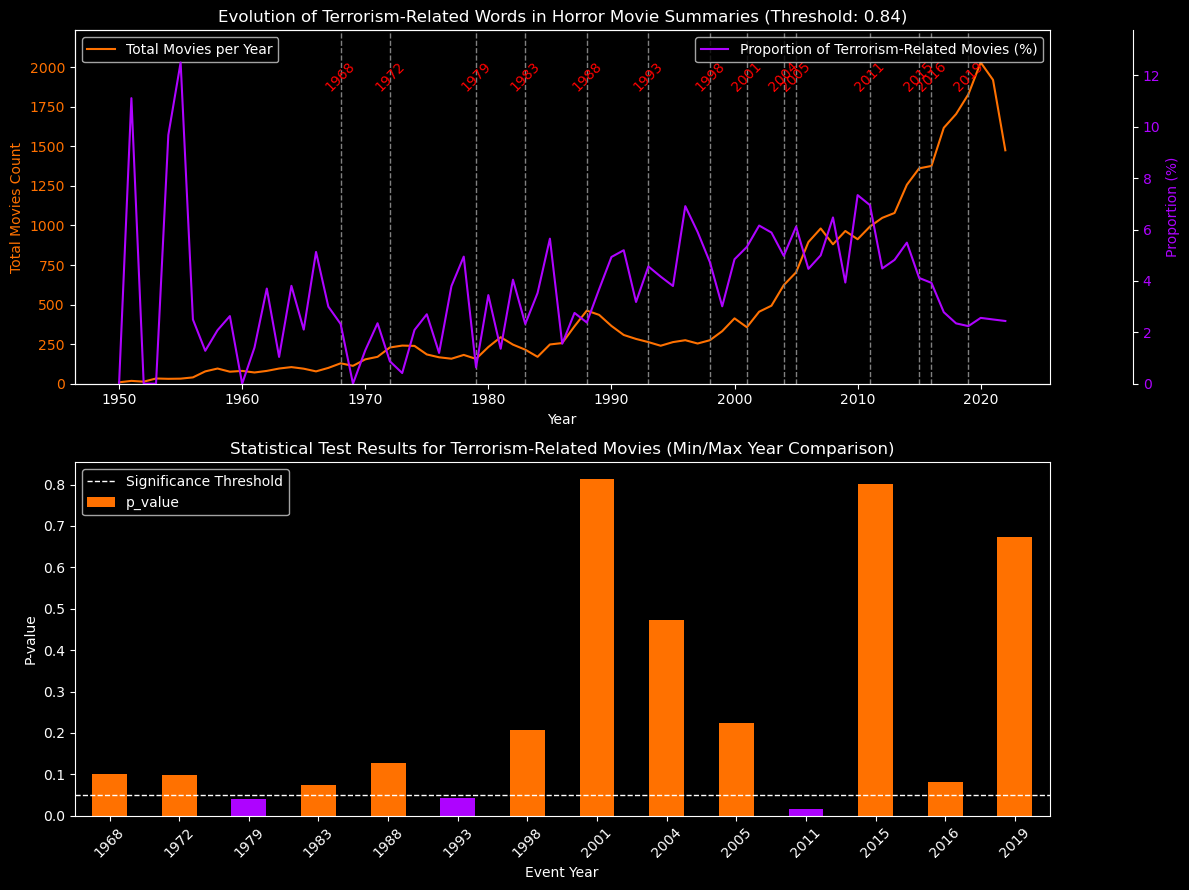

In [367]:
# 0.85 => 1983, 1993, 1998, 2011 //// 0.87 => 1998 //// 0.85 => 1993 
threshold = 0.84  # threshold above which a movies is considered as caontaing the terrorism subject
df_hist['Contains_terrorism'] = df_hist['Terrorism_similarity'].apply(lambda x: 1 if x > threshold else 0)

presence_terrorism = df_hist.groupby(df_hist["Release_year"])[['Contains_terrorism']].sum() # Total number of terrorism-related movies per year
total_movies_per_year = df_hist.groupby(df_hist["Release_year"])['Summary'].count() # Total number of movies per year
proportion_terrorism = presence_terrorism['Contains_terrorism'] / total_movies_per_year # Proportion of terrorism-related movies per year

terrorism_events = {
    1968: "Terrorist attacks at the Munich Olympics (Black September)",
    1972: "Munich Olympic Massacre (Palestinian Black September)",
    1979: "Iranian Hostage Crisis (U.S. Embassy in Tehran)",
    1983: "Beirut Barracks Bombings (Lebanon)",
    1988: "Lockerbie Bombing (Pan Am Flight 103)",
    1993: "World Trade Center Bombing (First Attack)",
    1998: "U.S. Embassy Bombings (Kenya and Tanzania)",
    2001: "9/11 Terrorist Attacks (U.S.)",
    2004: "Madrid Train Bombings (Spain)",
    2005: "London Bombings (7/7)",
    2011: "Terrorist Attacks in Norway (Oslo and Utoya Island)",
    2015: "Paris Attacks (Bataclan and other locations)",
    2016: "Brussels Bombings (Belgium)",
    2019: "Sri Lanka Easter Bombings (Churches and Hotels)",
}


## Statisticall test ##

years_of_interest = [1968, 1972, 1979, 1983, 1988, 1993, 1998, 2001, 2004, 2005, 2011, 2015, 2016, 2019]
results = {}

# Loop over each year of interest
for year in years_of_interest:
    # define the two ranges for comparison
    before_range = [year - 1, year, year + 1]
    after_range = [year, year + 1, year + 2, year + 3]
    
    # flu related movie in the year range
    before_counts = df_hist[df_hist['Release_year'].dt.year.isin(before_range)].groupby(df_hist['Release_year'].dt.year)['Contains_terrorism'].sum()
    after_counts = df_hist[df_hist['Release_year'].dt.year.isin(after_range)].groupby(df_hist['Release_year'].dt.year)['Contains_terrorism'].sum()
    
    # Year with the minimum and maximum occurrences of flu-related movies
    min_year = before_counts.idxmin() if not before_counts.empty else None
    max_year = after_counts.idxmax() if not after_counts.empty else None
    
    if min_year is not None and max_year is not None:
        # Year that will be tested
        min_year_data = df_hist[df_hist['Release_year'].dt.year == min_year]['Contains_terrorism']
        max_year_data = df_hist[df_hist['Release_year'].dt.year == max_year]['Contains_terrorism']
        
        #  Mann-Whitney U test 
        if len(min_year_data) > 0 and len(max_year_data) > 0:
            stat, p_value = mannwhitneyu(min_year_data, max_year_data)
            
            results[year] = {
                "statistic": stat,
                "p_value": p_value,
                "min_year": min_year,
                "max_year": max_year,
                "min_year_count": before_counts[min_year],
                "max_year_count": after_counts[max_year]
            }
    
    if year in results:
        print(f"Results for {year}:")
        print(f"Statistic: {results[year]['statistic']}")
        print(f"P-value: {results[year]['p_value']}")
        print(f"Min Year: {results[year]['min_year']} (Occurrences: {results[year]['min_year_count']})")
        print(f"Max Year: {results[year]['max_year']} (Occurrences: {results[year]['max_year_count']})")
        print("\n")
        
# Mann-Whitney U test
df_stats = pd.DataFrame(results).T
df_stats['Significant'] = df_stats['p_value'] < 0.05

plt.style.use('dark_background')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 9)) 

# Plot 1: Evolution of terrorism-telated words in horrmor movie
ax1 = axes[0]
ax1.set_title(f"Evolution of Terrorism-Related Words in Horror Movie Summaries (Threshold: {threshold:.2f})")
ax1.plot(total_movies_per_year.index, total_movies_per_year.values, color='#ff7100', label='Total Movies per Year')
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Movies Count", color='#ff7100')
ax1.tick_params(axis='y', labelcolor='#ff7100')
ax1.legend(loc='upper left')
ax1.set_ylim(0, total_movies_per_year.max() * 1.1)

# Percentage of terrorism-related movies
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('outward', 60)) 
ax2.plot(proportion_terrorism.index, proportion_terrorism * 100, color='#ae03ff', linestyle='-', label='Proportion of Terrorism-Related Movies (%)')
ax2.set_ylabel("Proportion (%)", color='#ae03ff')
ax2.tick_params(axis='y', labelcolor='#ae03ff')
ax2.legend(loc='upper right')
ax2.set_ylim(0, proportion_terrorism.max() * 100 * 1.1)

for year, event in terrorism_events.items():
    ax1.axvline(x=pd.to_datetime(str(year)), color='grey', linestyle='--', linewidth=1)
    ax1.text(pd.to_datetime(str(year)), total_movies_per_year.max() * 0.9, year, color='red', fontsize=10, 
             ha='center', va='bottom', rotation=45)

# Plot 2: P-value comparison
ax3 = axes[1]
df_stats['p_value'].plot(kind='bar', ax=ax3, color=df_stats['Significant'].map({True: '#ae03ff', False: '#ff7100'}))
ax3.set_xlabel('Event Year')
ax3.set_ylabel('P-value')
ax3.set_title('Statistical Test Results for Terrorism-Related Movies (Min/Max Year Comparison)')
ax3.axhline(y=0.05, color='white', linestyle='--', linewidth=1, label='Significance Threshold')
ax3.legend()
ax3.set_xticklabels(df_stats.index, rotation=45)

# Show the plots
plt.tight_layout()
plt.show()

For a threshold of 0.84, there are 3 range of years during wich the chnage in the occurance of terrorism related movies is significative. We would have expected to be after 9/11 in 2001. This method might lack of precision since the topic search might gather movies that are not really related to terrorism. Increasing the threshold might help, filtered these non related movies, but tends to decrease the number of movies considered.

## 2. Flu epidemics

Let's do the analysis for the flu epidemics taking into account the following historical dates:

In [356]:
# keywords related to flu subject, determined by chat-GPT
flu_keywords = ["flu", "influenza", "virus", "epidemic", "pandemic", "outbreak", 
                "contagion", "infection", "quarantine", "symptoms", "transmission", "contamination", 
                "vaccine", "immunity", "pathogen", "H5N1", "swine", "avian", "health", "fever", 
                "respiratory", "antiviral", "contagious"]

# calcualate the average vector of the flu-keywords
flu_vector = get_average_vector(flu_keywords, model)

# cosine similarity for each summary
df_hist['Flu_similarity'] = df_hist['Summary'].apply(lambda x: calculate_similarity(x, flu_vector, model))

Results for 1957:
Statistic: 1500.0
P-value: 0.4793556212262049
Min Year: 1956 (Occurrences: 0)
Max Year: 1959 (Occurrences: 1)


Results for 1968:
Statistic: 6450.0
P-value: 1.0
Min Year: 1967 (Occurrences: 0)
Max Year: 1968 (Occurrences: 0)


Results for 1977:
Statistic: 15113.5
P-value: 0.3410111459832835
Min Year: 1976 (Occurrences: 0)
Max Year: 1978 (Occurrences: 1)


Results for 1981:
Statistic: 28536.0
P-value: 0.33455349548920454
Min Year: 1980 (Occurrences: 0)
Max Year: 1982 (Occurrences: 1)


Results for 2003:
Statistic: 153141.5
P-value: 0.4398655374340834
Min Year: 2003 (Occurrences: 1)
Max Year: 2004 (Occurrences: 3)


Results for 2009:
Statistic: 436180.0
P-value: 0.001998281730484182
Min Year: 2009 (Occurrences: 0)
Max Year: 2010 (Occurrences: 9)




Results for 2013:
Statistic: 719092.0
P-value: 0.1886299621641533
Min Year: 2012 (Occurrences: 1)
Max Year: 2016 (Occurrences: 5)


Results for 2017:
Statistic: 1376701.5
P-value: 0.6544379079760778
Min Year: 2018 (Occurrences: 3)
Max Year: 2017 (Occurrences: 4)


Results for 2020:
Statistic: 1754102.0
P-value: 0.4487201177964093
Min Year: 2019 (Occurrences: 2)
Max Year: 2021 (Occurrences: 4)




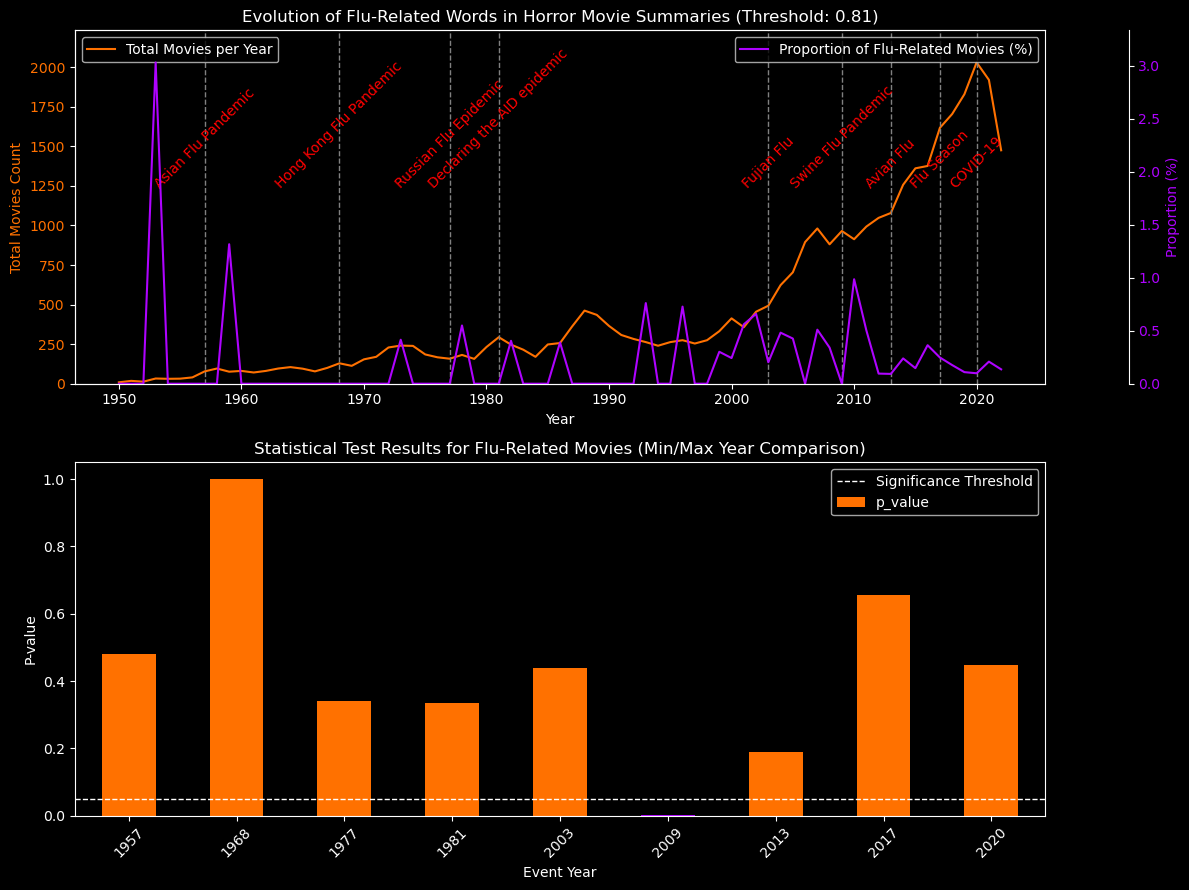

In [369]:
threshold = 0.81  # Threshold above which a movie is considered as containing keywords from the flu subject
df_hist['Contains_flu'] = df_hist['Flu_similarity'].apply(lambda x: 1 if x > threshold else 0)

# Grouping by year and calculating the total number of flu-related movies and proportion of flu-related movies
presence_flu = df_hist.groupby(df_hist["Release_year"])[['Contains_flu']].sum()  # Total number of flu-related movies per year
total_movies_per_year = df_hist.groupby(df_hist["Release_year"])['Summary'].count()  # Total number of movies per year
proportion_flu = presence_flu['Contains_flu'] / total_movies_per_year  # Proportion of flu-related movies per year

# Flu-related events (historical context)
flu_events = {
    1957: "Asian Flu Pandemic",
    1968: "Hong Kong Flu Pandemic",
    1977: "Russian Flu Epidemic",
    1981: "Declaring the AID epidemic",
    2003: "Fujian Flu",
    2009: "Swine Flu Pandemic",
    2013: "Avian Flu",
    2017: "Flu Season",
    2020: "COVID-19"
}

# Years of interest
years_of_interest = [1957, 1968, 1977, 1981, 2003, 2009, 2013, 2017, 2020]
results = {}

# Loop over each year of interest
for year in years_of_interest:
    # Define the two ranges for comparison
    before_range = [year - 1, year, year + 1]
    after_range = [year, year + 1, year + 2, year + 3]
    
    # Count of flu-related movies in the year range
    before_counts = df_hist[df_hist['Release_year'].dt.year.isin(before_range)].groupby(df_hist['Release_year'].dt.year)['Contains_flu'].sum()
    after_counts = df_hist[df_hist['Release_year'].dt.year.isin(after_range)].groupby(df_hist['Release_year'].dt.year)['Contains_flu'].sum()
    
    # Year with the minimum and maximum occurrences of flu-related movies
    min_year = before_counts.idxmin() if not before_counts.empty else None
    max_year = after_counts.idxmax() if not after_counts.empty else None
    
    if min_year is not None and max_year is not None:
        # Year that will be tested
        min_year_data = df_hist[df_hist['Release_year'].dt.year == min_year]['Contains_flu']
        max_year_data = df_hist[df_hist['Release_year'].dt.year == max_year]['Contains_flu']
        
        # Mann-Whitney U test
        if len(min_year_data) > 0 and len(max_year_data) > 0:
            stat, p_value = mannwhitneyu(min_year_data, max_year_data)
            
            results[year] = {
                "statistic": stat,
                "p_value": p_value,
                "min_year": min_year,
                "max_year": max_year,
                "min_year_count": before_counts[min_year],
                "max_year_count": after_counts[max_year]
            }
    
    if year in results:
        print(f"Results for {year}:")
        print(f"Statistic: {results[year]['statistic']}")
        print(f"P-value: {results[year]['p_value']}")
        print(f"Min Year: {results[year]['min_year']} (Occurrences: {results[year]['min_year_count']})")
        print(f"Max Year: {results[year]['max_year']} (Occurrences: {results[year]['max_year_count']})")
        print("\n")

# Mann-Whitney U test is significant if the p_value < 0.05
df_stats = pd.DataFrame(results).T
df_stats['Significant'] = df_stats['p_value'] < 0.05

# Plotting
plt.style.use('dark_background')

# Creating subplots for the visualizations
fig, axes = plt.subplots(2, 1, figsize=(12, 9)) 

# Plot 1: Evolution of Flu-Related Words in Horror Movie Summaries
ax1 = axes[0]
ax1.set_title(f"Evolution of Flu-Related Words in Horror Movie Summaries (Threshold: {threshold:.2f})")
ax1.plot(total_movies_per_year.index, total_movies_per_year.values, color='#ff7100', label='Total Movies per Year')
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Movies Count", color='#ff7100')
ax1.tick_params(axis='y', labelcolor='#ff7100')
ax1.legend(loc='upper left')
ax1.set_ylim(0, total_movies_per_year.max() * 1.1)

# Percentage of flu-related movies as a second y-axis
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('outward', 60))  # Offset to avoid overlap
ax2.plot(proportion_flu.index, proportion_flu * 100, color='#ae03ff', linestyle='-', label='Proportion of Flu-Related Movies (%)')
ax2.set_ylabel("Proportion (%)", color='#ae03ff')
ax2.tick_params(axis='y', labelcolor='#ae03ff')
ax2.legend(loc='upper right')
ax2.set_ylim(0, proportion_flu.max() * 100 * 1.1)

# Adding historical flu events to the plot
for year, event in flu_events.items():
    ax1.axvline(x=pd.to_datetime(str(year)), color='grey', linestyle='--', linewidth=1)
    ax1.text(pd.to_datetime(str(year)), total_movies_per_year.max() * 0.6, event, color='red', fontsize=10, 
             ha='center', va='bottom', rotation=45)

# Plot 2: P-value comparison
ax3 = axes[1]
df_stats['p_value'].plot(kind='bar', ax=ax3, color=df_stats['Significant'].map({True: '#ae03ff', False: '#ff7100'}))
ax3.set_xlabel('Event Year')
ax3.set_ylabel('P-value')
ax3.set_title('Statistical Test Results for Flu-Related Movies (Min/Max Year Comparison)')
ax3.axhline(y=0.05, color='white', linestyle='--', linewidth=1, label='Significance Threshold')
ax3.legend()
ax3.set_xticklabels(df_stats.index, rotation=45)

# Show the plots
plt.tight_layout()
plt.show()

For a threshold of 0.81, we can see that the only year for which the chnage in occurance of flu-related movies is the year 2009. This might be explained by the fact that it is the year of the swin flu which was officially declared a pandemic. It was one of the most mortel modern flu event. 

## 3. Petrol crisis

In [358]:
petrol_keywords = [
    "petrol", "gasoline", "fuel", "diesel", "oil", "petroleum", "refinery",
    "fossil", "combustion", "octane", "hydrocarbon", "energy", "gas", "barrel",
    "petrochemical", "pipeline", "engine", "exhaust", "car", "motor", "station",
    "pump", "tank", "auto", "transport", "drill", "rig", "spill", "smog", 
    "pollution", "traffic", "reserve", "price", "economy", "trade", "export",
    "import", "supply", "shortage", "demand", "industry", "market", "crisis",
    "tax", "subsidy"
]

petrol_vector = get_average_vector(petrol_keywords, model)

# Apply similarity check to each summary
df_hist['Petrol_similarity'] = df_hist['Summary'].apply(lambda x: calculate_similarity(x, petrol_vector, model))

Results for 1973:
Statistic: 26907.5
P-value: 0.04977571146128117
Min Year: 1972 (Occurrences: 0)
Max Year: 1974 (Occurrences: 4)


Results for 1979:
Statistic: 27739.0
P-value: 0.025976392293155993
Min Year: 1980 (Occurrences: 2)
Max Year: 1982 (Occurrences: 10)


Results for 1990:
Statistic: 78890.0
P-value: 0.5410857904544674
Min Year: 1989 (Occurrences: 8)
Max Year: 1990 (Occurrences: 9)


Results for 2008:
Statistic: 436781.0
P-value: 0.1739139682415346
Min Year: 2009 (Occurrences: 14)
Max Year: 2010 (Occurrences: 21)




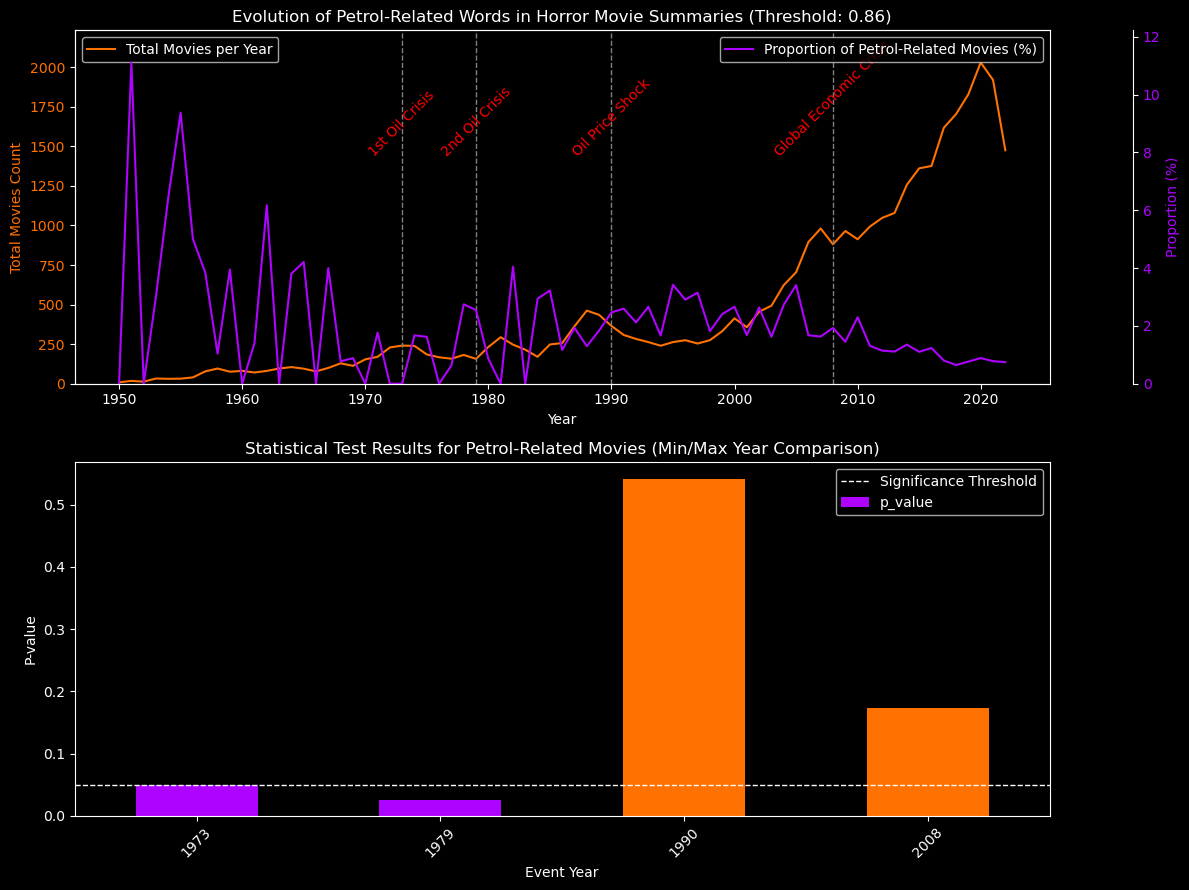

In [373]:
# 0.875 or 0.82 or 0.84 we have a significative p_value for 2008 /// 0.85 => 1973 and 1979
threshold = 0.86  # threshold above which a movie is considered as containing the petrol subject
df_hist['Contains_petrol'] = df_hist['Petrol_similarity'].apply(lambda x: 1 if x > threshold else 0)

presence_petrol = df_hist.groupby(df_hist["Release_year"])[['Contains_petrol']].sum()  # Total number of petrol-related movies per year
total_movies_per_year = df_hist.groupby(df_hist["Release_year"])['Summary'].count()  # Total number of movies per year
proportion_petrol = presence_petrol['Contains_petrol'] / total_movies_per_year  # Proportion of petrol-related movies per year

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 9))

# Plot 1: Total Movies and Proportion of Petrol-Related Movies
ax1 = axes[0]
ax1.set_title(f"Evolution of Petrol-Related Words in Horror Movie Summaries (Threshold: {threshold:.2f})")
ax1.plot(total_movies_per_year.index, total_movies_per_year.values, color='#ff7100', label='Total Movies per Year')
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Movies Count", color='#ff7100')
ax1.tick_params(axis='y', labelcolor='#ff7100')
ax1.legend(loc='upper left')
ax1.set_ylim(0, total_movies_per_year.max() * 1.1)

# Percentage of petrol-related movies as a second y-axis
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('outward', 60))  # Offset to avoid overlap with ax2
ax2.plot(proportion_petrol.index, proportion_petrol * 100, color='#ae03ff', linestyle='-', label='Proportion of Petrol-Related Movies (%)')
ax2.set_ylabel("Proportion (%)", color='#ae03ff')
ax2.tick_params(axis='y', labelcolor='#ae03ff')
ax2.legend(loc='upper right')
ax2.set_ylim(0, proportion_petrol.max() * 100 * 1.1)

# Significant petrol-related events
petrol_events = {
    1973: "1st Oil Crisis",
    1979: "2nd Oil Crisis",
    1990: "Oil Price Shock",
    2008: "Global Economic Crisis"
}

# Plotting the petrol events with vertical lines and labels
for year, event in petrol_events.items():
    ax1.axvline(x=pd.to_datetime(str(year)), color='grey', linestyle='--', linewidth=1)
    ax1.text(pd.to_datetime(str(year)), total_movies_per_year.max() * 0.7 , event, color='red', fontsize=10, 
             ha='center', va='bottom', rotation=45)

# Plot 2: P-value comparison for statistical tests
ax3 = axes[1]
years_of_interest = [1973, 1979, 1990, 2008]
results = {}

# Loop over each year of interest for statistical testing
for year in years_of_interest:
    # Define the two ranges for comparison (before and after the event)
    before_range = [year - 1, year, year + 1]
    after_range = [year, year + 1, year + 2, year + 3]
    
    # Counts for before and after years
    before_counts = df_hist[df_hist['Release_year'].dt.year.isin(before_range)].groupby(df_hist['Release_year'].dt.year)['Contains_petrol'].sum()
    after_counts = df_hist[df_hist['Release_year'].dt.year.isin(after_range)].groupby(df_hist['Release_year'].dt.year)['Contains_petrol'].sum()
    
    # Year with the minimum and maximum occurrences of petrol-related movies
    min_year = before_counts.idxmin() if not before_counts.empty else None
    max_year = after_counts.idxmax() if not after_counts.empty else None
    
    if min_year is not None and max_year is not None:
        # Year that will be tested
        min_year_data = df_hist[df_hist['Release_year'].dt.year == min_year]['Contains_petrol']
        max_year_data = df_hist[df_hist['Release_year'].dt.year == max_year]['Contains_petrol']
        
        # Mann-Whitney U test 
        if len(min_year_data) > 0 and len(max_year_data) > 0:
            stat, p_value = mannwhitneyu(min_year_data, max_year_data)
            
            results[year] = {
                "statistic": stat,
                "p_value": p_value,
                "min_year": min_year,
                "max_year": max_year,
                "min_year_count": before_counts[min_year],
                "max_year_count": after_counts[max_year]
            }
    
    if year in results:
        print(f"Results for {year}:")
        print(f"Statistic: {results[year]['statistic']}")
        print(f"P-value: {results[year]['p_value']}")
        print(f"Min Year: {results[year]['min_year']} (Occurrences: {results[year]['min_year_count']})")
        print(f"Max Year: {results[year]['max_year']} (Occurrences: {results[year]['max_year_count']})")
        print("\n")

# Mann-Whitney U test is significant if the p_value < 0.05
df_stats = pd.DataFrame(results).T
df_stats['Significant'] = df_stats['p_value'] < 0.05

# Plotting p_value comparison
df_stats['p_value'].plot(kind='bar', ax=ax3, color=df_stats['Significant'].map({True: '#ae03ff', False: '#ff7100'}))
ax3.set_xlabel('Event Year')
ax3.set_ylabel('P-value')
ax3.set_title('Statistical Test Results for Petrol-Related Movies (Min/Max Year Comparison)')
ax3.axhline(y=0.05, color='white', linestyle='--', linewidth=1, label='Significance Threshold')
ax3.legend()
ax3.set_xticklabels(df_stats.index, rotation=45)

plt.tight_layout()
plt.show()


For this threshold (0.86), we can see that 1973 an 1979 show a significative chnage in the number petrol related movies. Nevertheless, when looking at the graph, we can see that the year 1979 corresponds to a decrese in this number which is not was is expected when a petrol crisis occurs. The year 1973 is the most famous petrol crisis of our modern days, explaining the low p_value for this year. We can see that the p_value of all the years of the petrol topic is smaller than the p_value of the years of the other topics.

## 4. Communism

In [360]:
communism_keywords = [
    "communism", "equality", "revolution", "proletariat", "collectivism", "socialism", "Marxism",
    "class", "bourgeoisie", "labor", "solidarity", "state", "redistribution", "ideology",
    "party", "collective", "worker", "union", "comrade", "land", "people", "reform",
    "ownership", "struggle", "equality", "freedom", "manifesto", "nation", "policy",
    "community", "control", "authority", "dictatorship", "plan", "economy", "utopia",
    "power", "rights", "progress", "system", "justice", "common"
]


communism_vector = get_average_vector(communism_keywords, model)

# Apply similarity check to each summary
df_hist['Communism_similarity'] = df_hist['Summary'].apply(lambda x: calculate_similarity(x, communism_vector, model))

Results for 1953:
Statistic: 188.5
P-value: 0.37292436448900057
Min Year: 1952 (Occurrences: 0)
Max Year: 1954 (Occurrences: 2)


Results for 1956:
Statistic: 1200.0
P-value: 0.26783725954837634
Min Year: 1955 (Occurrences: 0)
Max Year: 1957 (Occurrences: 3)


Results for 1959:
Statistic: 2997.0
P-value: 0.14548841767294216
Min Year: 1960 (Occurrences: 0)
Max Year: 1959 (Occurrences: 2)


Results for 1961:
Statistic: 3199.5
P-value: 0.1585783250323708
Min Year: 1960 (Occurrences: 0)
Max Year: 1962 (Occurrences: 2)


Results for 1968:
Statistic: 6350.0
P-value: 0.21436728139890615
Min Year: 1967 (Occurrences: 0)
Max Year: 1968 (Occurrences: 2)


Results for 1975:
Statistic: 21749.0
P-value: 0.04877056206922264
Min Year: 1974 (Occurrences: 0)
Max Year: 1975 (Occurrences: 3)


Results for 1979:
Statistic: 19075.5
P-value: 0.11005526503126105
Min Year: 1979 (Occurrences: 0)
Max Year: 1982 (Occurrences: 4)


Results for 1980:
Statistic: 19075.5
P-value: 0.11005526503126105
Min Year: 1979 (O

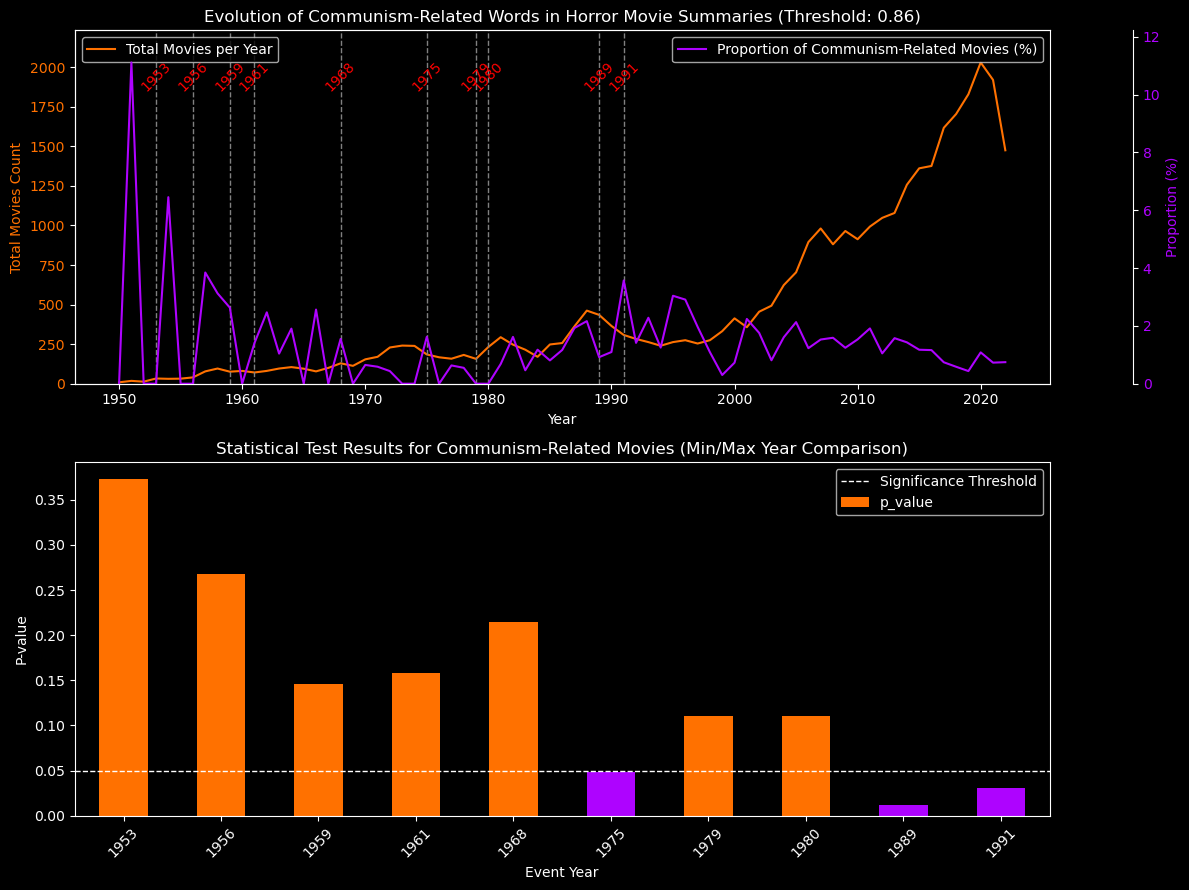

In [361]:
# at 0.85 => 1959, 1968, 1989  //  0.86 => 1969 19989 1991
threshold = 0.86  # Threshold above which a movie is considered as containing keywords from the communism subject
df_hist['Contains_communism'] = df_hist['Communism_similarity'].apply(lambda x: 1 if x > threshold else 0)

presence_communism = df_hist.groupby(df_hist["Release_year"])[['Contains_communism']].sum()  # Total number of communism-related movies per year
total_movies_per_year = df_hist.groupby(df_hist["Release_year"])['Summary'].count()  # Total number of movies per year
proportion_communism = presence_communism['Contains_communism'] / total_movies_per_year  # Proportion of communism-related movies per year

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 9))

# Plot 1: Total Movies and Proportion of Communism-Related Movies
ax1 = axes[0]
ax1.set_title(f"Evolution of Communism-Related Words in Horror Movie Summaries (Threshold: {threshold:.2f})")
ax1.plot(total_movies_per_year.index, total_movies_per_year.values, color='#ff7100', label='Total Movies per Year')
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Movies Count", color='#ff7100')
ax1.tick_params(axis='y', labelcolor='#ff7100')
ax1.legend(loc='upper left')
ax1.set_ylim(0, total_movies_per_year.max() * 1.1)

# Percentage of communism-related movies as a second y-axis
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('outward', 60))  # Offset to avoid overlap with ax2
ax2.plot(proportion_communism.index, proportion_communism * 100, color='#ae03ff', linestyle='-', label='Proportion of Communism-Related Movies (%)')
ax2.set_ylabel("Proportion (%)", color='#ae03ff')
ax2.tick_params(axis='y', labelcolor='#ae03ff')
ax2.legend(loc='upper right')
ax2.set_ylim(0, proportion_communism.max() * 100 * 1.1)

# Historical communism events determined with chat-GPT
communism_events = {
    1953: "Death of Joseph Stalin",
    1956: "Hungarian Uprising",
    1959: "Cuban Revolution",
    1961: "Construction of the Berlin Wall",
    1968: "Prague Spring and Soviet Invasion of Czechoslovakia",
    1975: "Fall of Saigon and End of the Vietnam War",
    1979: "Soviet Invasion of Afghanistan",
    1980: "Solidarity Movement in Poland Begins",
    1989: "Fall of the Berlin Wall",
    1991: "Dissolution of the Soviet Union"
}

# Plotting the communism events with vertical lines and labels
for year, event in communism_events.items():
    ax1.axvline(x=pd.to_datetime(str(year)), color='grey', linestyle='--', linewidth=1)
    ax1.text(pd.to_datetime(str(year)), total_movies_per_year.max() * 0.9, year, color='red', fontsize=10, 
             ha='center', va='bottom', rotation=45)

# Plot 2: P-value comparison for statistical tests
ax3 = axes[1]
years_of_interest = [1953, 1956, 1959, 1961, 1968, 1975, 1979, 1980, 1989, 1991]
results = {}

# Loop over each year of interest for statistical testing
for year in years_of_interest:
    # Define the two ranges for comparison (before and after the event)
    before_range = [year - 1, year, year + 1]
    after_range = [year, year + 1, year + 2, year + 3]
    
    # Counts for before and after years
    before_counts = df_hist[df_hist['Release_year'].dt.year.isin(before_range)].groupby(df_hist['Release_year'].dt.year)['Contains_communism'].sum()
    after_counts = df_hist[df_hist['Release_year'].dt.year.isin(after_range)].groupby(df_hist['Release_year'].dt.year)['Contains_communism'].sum()
    
    # Year with the minimum and maximum occurrences of communism-related movies
    min_year = before_counts.idxmin() if not before_counts.empty else None
    max_year = after_counts.idxmax() if not after_counts.empty else None
    
    if min_year is not None and max_year is not None:
        # Year that will be tested
        min_year_data = df_hist[df_hist['Release_year'].dt.year == min_year]['Contains_communism']
        max_year_data = df_hist[df_hist['Release_year'].dt.year == max_year]['Contains_communism']
        
        # Mann-Whitney U test 
        if len(min_year_data) > 0 and len(max_year_data) > 0:
            stat, p_value = mannwhitneyu(min_year_data, max_year_data)
            
            results[year] = {
                "statistic": stat,
                "p_value": p_value,
                "min_year": min_year,
                "max_year": max_year,
                "min_year_count": before_counts[min_year],
                "max_year_count": after_counts[max_year]
            }
    
    if year in results:
        print(f"Results for {year}:")
        print(f"Statistic: {results[year]['statistic']}")
        print(f"P-value: {results[year]['p_value']}")
        print(f"Min Year: {results[year]['min_year']} (Occurrences: {results[year]['min_year_count']})")
        print(f"Max Year: {results[year]['max_year']} (Occurrences: {results[year]['max_year_count']})")
        print("\n")

# Mann-Whitney U test is significant if the p_value < 0.05
df_stats = pd.DataFrame(results).T
df_stats['Significant'] = df_stats['p_value'] < 0.05

# Plotting p_value comparison
df_stats['p_value'].plot(kind='bar', ax=ax3, color=df_stats['Significant'].map({True: '#ae03ff', False: '#ff7100'}))
ax3.set_xlabel('Event Year')
ax3.set_ylabel('P-value')
ax3.set_title('Statistical Test Results for Communism-Related Movies (Min/Max Year Comparison)')
ax3.axhline(y=0.05, color='white', linestyle='--', linewidth=1, label='Significance Threshold')
ax3.legend()
ax3.set_xticklabels(df_stats.index, rotation=45)

plt.tight_layout()
plt.show()


For the communism topic, we can see that we have 4 significative years in our analysis. As we know, the Berlin Wall fall in 1989 and the dissolution of Soviet Union are the most important worldwide events. Nevertheless, the Solidarity Movement in Poland Begins, in 1980, is not really a marking event. This could be explained by the fact that tehre is an event in 1979 and one in 1980, thus leading to an close accumulation of movues realated to communism. The significative p_value for the year 1979, corresponds to a decrese in the number of occruance of communism related movies. 

## 5. Nuclear

In [362]:
nuclear_keywords = ["nuclear", "radiation", "reactor", "uranium", "plutonium", "fission", "meltdown", 
                    "contamination", "fallout", "isotopes", "fusion", "bomb", "waste", "exposure", 
                    "decay", "energy", "hazard", "reactor", "evacuation", "crisis", "leak", "disaster", 
                    "shelter", "emergency", "cooling", "shield", "toxic", "cloud", "blast", "pollution", 
                    "danger", "contaminant", "half-life"]


nuclear_vector = get_average_vector(nuclear_keywords, model)

# Apply similarity check to each summary
df_hist['Nuclear_similarity'] = df_hist['Summary'].apply(lambda x: calculate_similarity(x, nuclear_vector, model))

Results for 1957:
Statistic: 1900.0
P-value: 0.5291135338317555
Min Year: 1956 (Occurrences: 0)
Max Year: 1958 (Occurrences: 1)


Results for 1961:
Statistic: 3240.0
P-value: 0.32332197287355946
Min Year: 1960 (Occurrences: 0)
Max Year: 1962 (Occurrences: 1)


Results for 1969:
Statistic: 6384.5
P-value: 1.0
Min Year: 1969 (Occurrences: 0)
Max Year: 1969 (Occurrences: 0)


Results for 1979:
Statistic: 28311.5
P-value: 0.20205362817221506
Min Year: 1980 (Occurrences: 1)
Max Year: 1982 (Occurrences: 4)


Results for 1986:
Statistic: 83127.0
P-value: 0.07592705284285177
Min Year: 1987 (Occurrences: 0)
Max Year: 1988 (Occurrences: 4)


Results for 1999:
Statistic: 56650.5
P-value: 0.7399505864061294
Min Year: 1998 (Occurrences: 2)
Max Year: 2000 (Occurrences: 4)


Results for 2011:
Statistic: 516554.0
P-value: 0.05501008226690878
Min Year: 2012 (Occurrences: 4)
Max Year: 2011 (Occurrences: 11)




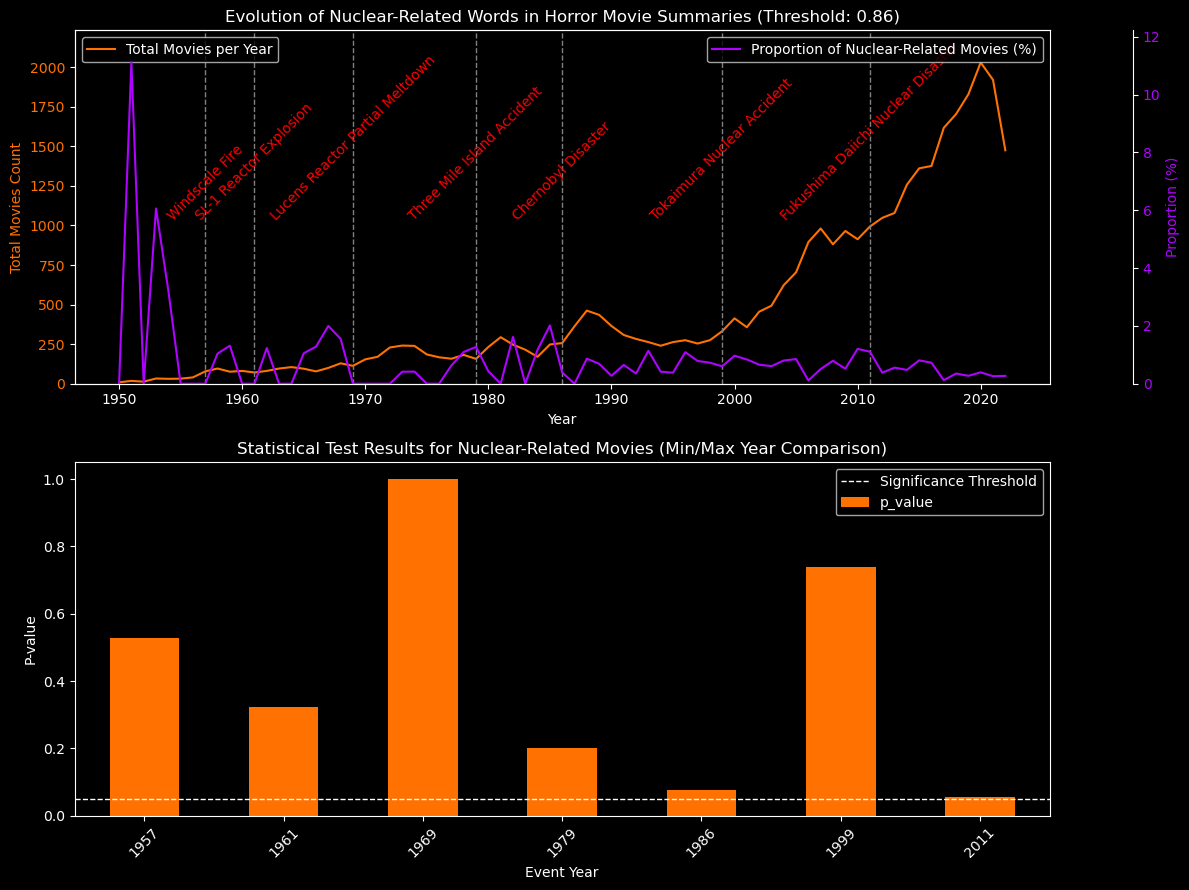

In [378]:
# at 0.85 => 1959, 1968, 1989  //  0.86 => 1969 19989 1991
threshold = 0.86  # Threshold above which a movie is considered as containing keywords from the nuclear subject
df_hist['Contains_nuclear'] = df_hist['Nuclear_similarity'].apply(lambda x: 1 if x > threshold else 0)

presence_nuclear = df_hist.groupby(df_hist["Release_year"])[['Contains_nuclear']].sum()  # Total number of nuclear-related movies per year
total_movies_per_year = df_hist.groupby(df_hist["Release_year"])['Summary'].count()  # Total number of movies per year
proportion_nuclear = presence_nuclear['Contains_nuclear'] / total_movies_per_year  # Proportion of nuclear-related movies per year

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 9))

# Plot 1: Total Movies and Proportion of Nuclear-Related Movies
ax1 = axes[0]
ax1.set_title(f"Evolution of Nuclear-Related Words in Horror Movie Summaries (Threshold: {threshold:.2f})")
ax1.plot(total_movies_per_year.index, total_movies_per_year.values, color='#ff7100', label='Total Movies per Year')
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Movies Count", color='#ff7100')
ax1.tick_params(axis='y', labelcolor='#ff7100')
ax1.legend(loc='upper left')
ax1.set_ylim(0, total_movies_per_year.max() * 1.1)

# Percentage of nuclear-related movies as a second y-axis
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('outward', 60))  # Offset to avoid overlap with ax2
ax2.plot(proportion_nuclear.index, proportion_nuclear * 100, color='#ae03ff', linestyle='-', label='Proportion of Nuclear-Related Movies (%)')
ax2.set_ylabel("Proportion (%)", color='#ae03ff')
ax2.tick_params(axis='y', labelcolor='#ae03ff')
ax2.legend(loc='upper right')
ax2.set_ylim(0, proportion_nuclear.max() * 100 * 1.1)

# Historical nuclear events determined with Chat-GPT
nuclear_events = {
    1957: "Kyshtym Disaster",
    1957: "Windscale Fire",
    1961: "SL-1 Reactor Explosion",
    1969: "Lucens Reactor Partial Meltdown",
    1979: "Three Mile Island Accident",
    1986: "Chernobyl Disaster",
    1999: "Tokaimura Nuclear Accident",
    2011: "Fukushima Daiichi Nuclear Disaster"
}

# Plotting the nuclear events with vertical lines and labels
for year, event in nuclear_events.items():
    ax1.axvline(x=pd.to_datetime(str(year)), color='grey', linestyle='--', linewidth=1)
    ax1.text(pd.to_datetime(str(year)), total_movies_per_year.max() * 0.5 , event, color='red', fontsize=10, 
             ha='center', va='bottom', rotation=45)

# Plot 2: P-value comparison for statistical tests
ax3 = axes[1]
years_of_interest = [1957, 1961, 1969, 1979, 1986, 1999, 2011]
results = {}

# Loop over each year of interest for statistical testing
for year in years_of_interest:
    # Define the two ranges for comparison (before and after the event)
    before_range = [year - 1, year, year + 1]
    after_range = [year, year + 1, year + 2, year + 3]
    
    # Counts for before and after years
    before_counts = df_hist[df_hist['Release_year'].dt.year.isin(before_range)].groupby(df_hist['Release_year'].dt.year)['Contains_nuclear'].sum()
    after_counts = df_hist[df_hist['Release_year'].dt.year.isin(after_range)].groupby(df_hist['Release_year'].dt.year)['Contains_nuclear'].sum()
    
    # Year with the minimum and maximum occurrences of nuclear-related movies
    min_year = before_counts.idxmin() if not before_counts.empty else None
    max_year = after_counts.idxmax() if not after_counts.empty else None
    
    if min_year is not None and max_year is not None:
        # Year that will be tested
        min_year_data = df_hist[df_hist['Release_year'].dt.year == min_year]['Contains_nuclear']
        max_year_data = df_hist[df_hist['Release_year'].dt.year == max_year]['Contains_nuclear']
        
        # Mann-Whitney U test
        if len(min_year_data) > 0 and len(max_year_data) > 0:
            stat, p_value = mannwhitneyu(min_year_data, max_year_data)
            
            results[year] = {
                "statistic": stat,
                "p_value": p_value,
                "min_year": min_year,
                "max_year": max_year,
                "min_year_count": before_counts[min_year],
                "max_year_count": after_counts[max_year]
            }
    
    if year in results:
        print(f"Results for {year}:")
        print(f"Statistic: {results[year]['statistic']}")
        print(f"P-value: {results[year]['p_value']}")
        print(f"Min Year: {results[year]['min_year']} (Occurrences: {results[year]['min_year_count']})")
        print(f"Max Year: {results[year]['max_year']} (Occurrences: {results[year]['max_year_count']})")
        print("\n")

# Mann-Whitney U test is significant if the p_value < 0.05
df_stats = pd.DataFrame(results).T
df_stats['Significant'] = df_stats['p_value'] < 0.05

# Plotting p_value comparison
df_stats['p_value'].plot(kind='bar', ax=ax3, color=df_stats['Significant'].map({True: '#ae03ff', False: '#ff7100'}))
ax3.set_xlabel('Event Year')
ax3.set_ylabel('P-value')
ax3.set_title('Statistical Test Results for Nuclear-Related Movies (Min/Max Year Comparison)')
ax3.axhline(y=0.05, color='white', linestyle='--', linewidth=1, label='Significance Threshold')
ax3.legend()
ax3.set_xticklabels(df_stats.index, rotation=45)

plt.tight_layout()
plt.show()


According to these graphs, att a threshold of 0.86, we can see that the year 1986 is almost significative. This corresponds to the chernobyl nuclear dissaster. Note that the year 2011 is also almost significative. This year corresponds to the fukushima disaster. Nevertheless, these values correspond tot a decresing trends in the graph. 